In [1]:
import pandas as pd
from deepface import DeepFace

In [2]:
df = pd.read_csv('../../dataset/Labeled Faces in the Wild Dataset/master.csv')
df.head()

,file_x,file_y,Decision
0,img20.jpg,img21.jpg,Yes
1,img16.jpg,img17.jpg,Yes
2,img3.jpg,img12.jpg,Yes
3,img22.jpg,img23.jpg,Yes
4,img24.jpg,img25.jpg,Yes


In [3]:
df['file_x'] = '../../dataset/Labeled Faces in the Wild Dataset/' + df['file_x'].astype(str)
df['file_y'] = '../../dataset/Labeled Faces in the Wild Dataset/' + df['file_y'].astype(str)

In [4]:
instances = df[["file_x", "file_y"]].values.tolist()
instances

[['../../dataset/Labeled Faces in the Wild Dataset/img20.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img21.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img16.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img17.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img3.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img12.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img22.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img23.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img24.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img25.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img1.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img2.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img1.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img4.jpg'],
 ['../../dataset/Labeled Faces in the Wild Dataset/img1.jpg',
  '../../dataset/Labeled Faces in the Wild Dataset/img

In [5]:
model_name = "Facenet"
distance_metric = "euclidean"

In [6]:
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric)

Verification: 100%|██████████| 300/300 [23:49<00:00,  4.77s/it]


In [23]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [24]:
df["distance"] = distances
df.head()

,file_x,file_y,Decision,distance,prediction
0,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,Yes,5.2676,No
1,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,Yes,7.5863,No
2,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,Yes,10.5049,No
3,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,Yes,8.2893,No
4,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,Yes,5.2594,No


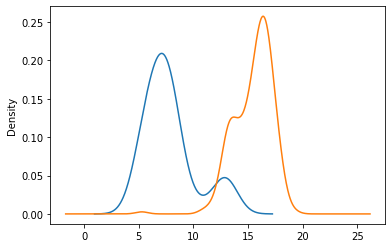

In [25]:
df[df.Decision == "Yes"].distance.plot.kde()
df[df.Decision == "No"].distance.plot.kde()

In [26]:
from chefboost import Chefboost as chef

In [27]:
config = {'algorithm': 'C4.5'}

In [28]:
tmp_df = df[['distance', 'Decision']].rename(columns = {"decision": "Decision"}).copy()
model = chef.fit(tmp_df, config)

[INFO]:  2 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.503995418548584  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  97.33333333333333 % on  300  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[33, 3], [5, 259]]
Precision:  91.6667 %, Recall:  86.8421 %, F1:  89.1892 %


In [29]:
threshold = 11.397 #comes from c4.5 algorithm

In [30]:
df["prediction"] = "No"

In [31]:
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'

In [32]:
df.sample(5)

,file_x,file_y,Decision,distance,prediction
97,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,No,15.6814,No
199,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,No,16.6004,No
52,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,No,16.6027,No
13,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,Yes,5.5755,Yes
192,../../dataset/Labeled Faces in the Wild Datase...,../../dataset/Labeled Faces in the Wild Datase...,No,13.0603,No


In [33]:
from sklearn.metrics import confusion_matrix,roc_curve,auc

In [34]:
cm = confusion_matrix(df.Decision.values, df.prediction.values)

In [35]:
tn, fp, fn, tp = cm.ravel()

In [36]:
tn, fp, fn, tp

(259, 3, 5, 33)

In [37]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [38]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  91.66666666666666 %
Recall:  86.8421052631579 %
F1 score  89.18918918918918 %
Accuracy:  97.33333333333334 %


In [104]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
df["p"] = "No"
roc_point=[]

In [106]:
thresholds = list(np.array(list(range(1,100,5)))/100)
for threshold in thresholds:
    idx = df[df.distance <= threshold].index
    df.loc[idx, 'p'] = 'Yes'
    cm = confusion_matrix(df.Decision.values, df.p.values)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    fpr = tp / (tp + fp)
    roc_point.append([tpr,fpr])
roc_point

[[0.0, nan],
 [0.0, nan],
 [0.10526315789473684, 1.0],
 [0.2631578947368421, 1.0],
 [0.5789473684210527, 1.0],
 [0.7631578947368421, 1.0],
 [0.7894736842105263, 0.967741935483871],
 [0.7894736842105263, 0.967741935483871],
 [0.8157894736842105, 0.96875],
 [0.8157894736842105, 0.96875],
 [0.8157894736842105, 0.96875],
 [0.8157894736842105, 0.96875],
 [0.8157894736842105, 0.8157894736842105],
 [0.8157894736842105, 0.6458333333333334],
 [0.8157894736842105, 0.5166666666666667],
 [0.8157894736842105, 0.43661971830985913],
 [0.8421052631578947, 0.367816091954023],
 [0.9210526315789473, 0.3181818181818182],
 [0.9736842105263158, 0.25517241379310346],
 [1.0, 0.1958762886597938]]

In [107]:
pivot = pd.DataFrame(roc_point,columns = ['tpr','fpr'])
pivot["threshold"] = thresholds
pivot                    

,tpr,fpr,threshold
0,0.000000,NaN,0.01
1,0.000000,NaN,0.06
2,0.105263,1.000000,0.11
3,0.263158,1.000000,0.16
4,0.578947,1.000000,0.21
5,0.763158,1.000000,0.26
6,0.789474,0.967742,0.31
7,0.789474,0.967742,0.36
8,0.815789,0.968750,0.41
9,0.815789,0.968750,0.46


In [1]:
plt.scatter(pivot.fpr,pivot.tpr)

NameError: name 'plt' is not defined